### NLP - Notebook 5
### Deep Learning Models

In [1]:
from numpy import array
from numpy import asarray
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [2]:
# Import our cleaned dataset
nlpdata = pd.read_csv('Data\X_no_stop_words.csv')
nlpdata.head()

,no_stop_words
0,w7718 w173355 w138132 w232277 w314686 w292000 ...
1,w195317 w127737 w171593 w22890 w342007 w289824...
2,w261113 w366000 w378735 w500012 w306830 w20025...
3,w286461 w308610 w27013 w272605 w287214 w15393 ...
4,w135431 w115724 w331534 w256214 w71240 w326106...


In [3]:
nlpdata['no_stop_words'][0]

'w7718 w173355 w138132 w232277 w314686 w292000 w148650 w220790 w20894 w500010 w136109 w172358 w66535 w80220 w255783 w15393 '

In [4]:
# Retrieve the labels 
train_data = pd.read_csv ('Data\TIL_NLP_train_dataset.csv')

In [5]:
y = train_data.drop(columns=['id', 'word_representation'])

In [6]:
y = y.values

In [7]:
y

array([[1, 0, 1, 0, 0],
       [1, 0, 1, 0, 0],
       [0, 1, 1, 0, 0],
       ...,
       [1, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 1, 0, 0]], dtype=int64)

### Multi-lable Text Classification Model with Single Output Layer

In [8]:
X = []
sentences = list(nlpdata['no_stop_words'])
for sen in sentences:
    X.append(sen)

In [11]:
# Tokenize the data into individual words 
from nltk.tokenize import word_tokenize
all_words = []
for sent in X:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)

In [12]:
# Get the number of unique words 
unique_words = set(all_words)
print(len(unique_words))

4160


In [13]:
# We want to count the number of words in each row and find the longest case
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(sentences, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

In [14]:
length_long_sentence

36

The longest row as 36 words.  We will pad rows to match this length for uniformity.

In [16]:
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [17]:
# We tokenize the data and pad each sequence to match the longest lenght we found - 36 tokens.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 36

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [19]:
X_train

array([[ 775,   97,  200, ...,    0,    0,    0],
       [ 310,  403,  108, ...,    0,    0,    0],
       [   7,  211,    4, ...,    0,    0,    0],
       ...,
       [  88,  364,  482, ...,    0,    0,    0],
       [ 297,  152,  164, ...,    0,    0,    0],
       [ 511, 2230,  192, ...,    0,    0,    0]])

In [20]:
X_train.shape

(5904, 36)

So we have 5,904 rows of training data and row matches the length of the longest row - 36 entries.

In [21]:
y_train

array([[0, 1, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [0, 1, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 1],
       [1, 0, 1, 0, 0]], dtype=int64)

In [22]:
y_train.shape

(5904, 5)

We will now create an embedding layer using our word embeddings file.  This will be used in the deep learning models as an embedding layer.

In [23]:
import pickle
with open ('Data\word_embeddings.pkl', 'rb') as file:
    embeddings = pickle.load(file)

In [24]:
embeddings_dictionary = dict()

for line in embeddings.keys():
    records = embeddings[line]
    word = line
    vector_dimensions = asarray(records[:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

In [25]:
# Here we create the embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [26]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34904999, -0.018456  , -0.32291999, ..., -0.044779  ,
         0.12902001, -0.23039   ],
       [ 0.11302   ,  0.51802999, -0.61565   , ...,  0.34717   ,
        -0.21518999, -0.13248999],
       ...,
       [ 0.080462  , -0.23085999,  0.040204  , ...,  0.32157999,
         0.77864999,  0.072076  ],
       [-0.80576998, -0.42262   , -0.0061334 , ..., -1.03289998,
        -0.36798999, -0.14947   ],
       [ 0.67958999, -0.12808   ,  0.023239  , ..., -0.11294   ,
        -0.29925001,  0.38870999]])

In [27]:
embedding_matrix.shape

(3881, 100)

The matrix creates a 100-dimensional vector for each of the unique words in our training dataset.  

In [28]:
# Create the deep learning model with one output layer 
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(5, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [29]:
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 36, 100)           388100    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 505,993
Trainable params: 117,893
Non-trainable params: 388,100
_________________________________________________________________
None


# Test the model for 20 epochs

In [30]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
37/37 [==============================] - 2s 54ms/step - loss: 0.6007 - acc: 0.1925 - val_loss: 0.5501 - val_acc: 0.2557
Epoch 2/20
37/37 [==============================] - 2s 42ms/step - loss: 0.5205 - acc: 0.2331 - val_loss: 0.4937 - val_acc: 0.3243
Epoch 3/20
37/37 [==============================] - 1s 38ms/step - loss: 0.4621 - acc: 0.2920 - val_loss: 0.4425 - val_acc: 0.3387
Epoch 4/20
37/37 [==============================] - 1s 37ms/step - loss: 0.4030 - acc: 0.3303 - val_loss: 0.3663 - val_acc: 0.4412
Epoch 5/20
37/37 [==============================] - 1s 37ms/step - loss: 0.3177 - acc: 0.4921 - val_loss: 0.2908 - val_acc: 0.5978
Epoch 6/20
37/37 [==============================] - 1s 38ms/step - loss: 0.2660 - acc: 0.5640 - val_loss: 0.2596 - val_acc: 0.5555
Epoch 7/20
37/37 [==============================] - 1s 38ms/step - loss: 0.2229 - acc: 0.5723 - val_loss: 0.2277 - val_acc: 0.5927
Epoch 8/20
37/37 [==============================] - 1s 38ms/step - loss: 0.1789 - a

In [31]:
# Evaluate the model on the test dataset
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

47/47 [==============================] - 0s 6ms/step - loss: 0.1199 - acc: 0.5000
Test Score: 0.11986026912927628
Test Accuracy: 0.5


We achieve an accuracy of only 50% using this model.

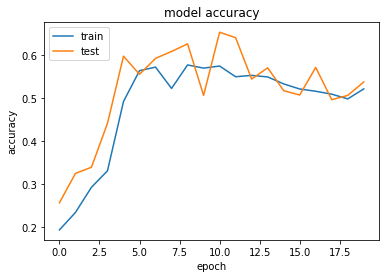

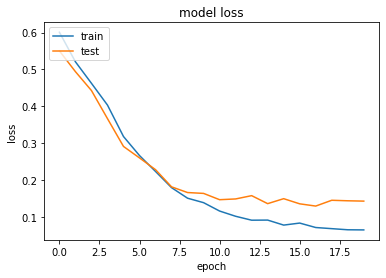

In [32]:
# Plotting the accuracies and lost over the epochs
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Multi-lable Text Classification Model with Multiple Output Layers

In [33]:
X = []
sentences = list(nlpdata['no_stop_words'])
for sen in sentences:
    X.append(sen)

In [34]:
y = train_data.drop(columns=['id', 'word_representation'])

In [35]:
y

,outwear,top,trousers,women dresses,women skirts
0,1,0,1,0,0
1,1,0,1,0,0
2,0,1,1,0,0
3,1,0,1,0,0
4,1,0,1,0,0
...,...,...,...,...,...
7375,0,1,1,0,0
7376,1,1,0,0,0
7377,1,0,1,0,0
7378,1,1,0,0,0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

After following the same procedure as above now split according to class labels to create five output layers

In [37]:
# First output
y1_train = y_train[["outwear"]].values
y1_test =  y_test[["outwear"]].values

# Second output
y2_train = y_train[["top"]].values
y2_test =  y_test[["top"]].values

# Third output
y3_train = y_train[["trousers"]].values
y3_test =  y_test[["trousers"]].values

# Fourth output
y4_train = y_train[["women dresses"]].values
y4_test =  y_test[["women dresses"]].values

# Fifth output
y5_train = y_train[["women skirts"]].values
y5_test =  y_test[["women skirts"]].values

In [38]:
# Tokenize and pad the sequences as before 

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 36

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [39]:
# Create the embedding matrix

embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [40]:
# Create the model with one output layer for each of the class labels

input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2, output3, output4, output5])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [41]:
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 36, 100)      388100      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          117248      embedding_1[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            129         lstm_1[0][0]                     
_______________________________________________________________________________________

In [42]:
# Test the model for 20 epochs
history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train], batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
37/37 [==============================] - 2s 53ms/step - loss: 3.0115 - dense_1_loss: 0.7008 - dense_2_loss: 0.6895 - dense_3_loss: 0.6728 - dense_4_loss: 0.4845 - dense_5_loss: 0.4639 - dense_1_acc: 0.4988 - dense_2_acc: 0.5547 - dense_3_acc: 0.5780 - dense_4_acc: 0.8245 - dense_5_acc: 0.8251 - val_loss: 2.7801 - val_dense_1_loss: 0.6992 - val_dense_2_loss: 0.6851 - val_dense_3_loss: 0.6633 - val_dense_4_loss: 0.3719 - val_dense_5_loss: 0.3604 - val_dense_1_acc: 0.5064 - val_dense_2_acc: 0.5936 - val_dense_3_acc: 0.6588 - val_dense_4_acc: 0.8290 - val_dense_5_acc: 0.8366
Epoch 2/20
37/37 [==============================] - 1s 34ms/step - loss: 2.5271 - dense_1_loss: 0.6774 - dense_2_loss: 0.6710 - dense_3_loss: 0.5493 - dense_4_loss: 0.3179 - dense_5_loss: 0.3115 - dense_1_acc: 0.5863 - dense_2_acc: 0.5856 - dense_3_acc: 0.7264 - dense_4_acc: 0.8478 - dense_5_acc: 0.8465 - val_loss: 2.3464 - val_dense_1_loss: 0.6531 - val_dense_2_loss: 0.6033 - val_dense_3_loss: 0.4711 - val_

Epoch 15/20
37/37 [==============================] - 1s 34ms/step - loss: 0.4246 - dense_1_loss: 0.1571 - dense_2_loss: 0.1374 - dense_3_loss: 0.0776 - dense_4_loss: 0.0325 - dense_5_loss: 0.0200 - dense_1_acc: 0.9490 - dense_2_acc: 0.9547 - dense_3_acc: 0.9771 - dense_4_acc: 0.9920 - dense_5_acc: 0.9956 - val_loss: 0.7702 - val_dense_1_loss: 0.2577 - val_dense_2_loss: 0.2081 - val_dense_3_loss: 0.1851 - val_dense_4_loss: 0.0573 - val_dense_5_loss: 0.0621 - val_dense_1_acc: 0.9145 - val_dense_2_acc: 0.9229 - val_dense_3_acc: 0.9441 - val_dense_4_acc: 0.9873 - val_dense_5_acc: 0.9865
Epoch 16/20
37/37 [==============================] - 1s 34ms/step - loss: 0.4006 - dense_1_loss: 0.1405 - dense_2_loss: 0.1368 - dense_3_loss: 0.0766 - dense_4_loss: 0.0275 - dense_5_loss: 0.0192 - dense_1_acc: 0.9560 - dense_2_acc: 0.9566 - dense_3_acc: 0.9767 - dense_4_acc: 0.9936 - dense_5_acc: 0.9960 - val_loss: 0.8047 - val_dense_1_loss: 0.2788 - val_dense_2_loss: 0.2098 - val_dense_3_loss: 0.1831 - va

In [43]:
# Check the accuracy on the testing data
score = model.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test], verbose=1)
score

47/47 [==============================] - 0s 6ms/step - loss: 0.5873 - dense_1_loss: 0.1935 - dense_2_loss: 0.2099 - dense_3_loss: 0.1237 - dense_4_loss: 0.0304 - dense_5_loss: 0.0298 - dense_1_acc: 0.9390 - dense_2_acc: 0.9363 - dense_3_acc: 0.9627 - dense_4_acc: 0.9905 - dense_5_acc: 0.9946


[0.5873477458953857,
 0.19346225261688232,
 0.20992760360240936,
 0.1237347275018692,
 0.030403364449739456,
 0.02981983684003353,
 0.9390243887901306,
 0.9363143444061279,
 0.9627371430397034,
 0.9905149340629578,
 0.9945799708366394]

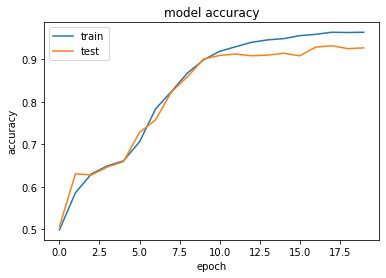

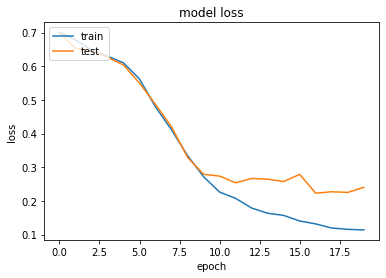

In [44]:
# Plot the accuracy and loss over the epochs for one of the class labels

plt.plot(history.history['dense_1_acc'])
plt.plot(history.history['val_dense_1_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['val_dense_1_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

This model works extremely well. 